# X-ray challenge

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd ./drive/MyDrive/raw_data


/content/drive/MyDrive/raw_data


In [3]:
%ls


bacterial_pneumonia/  covid-19/  normal/  viral_pneumonia/


In [4]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib.pyplot import imread
import pathlib

In [5]:
print(tf.__version__)

2.4.1


In [6]:
dataset_path = "/content/drive/MyDrive/trainset _balanced"

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(256, 256), 
  batch_size=32)

Found 3136 files belonging to 4 classes.
Using 2509 files for training.


In [8]:
train_ds

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(256, 256),
  batch_size=32)

Found 3136 files belonging to 4 classes.
Using 627 files for validation.


In [10]:
val_ds

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [11]:
class_names = train_ds.class_names
print(class_names)

['bacterial_pneumonia', 'covid-19', 'normal', 'viral_pneumonia']


In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 256, 256, 3)
(32,)


In [13]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [14]:
#from tensorflow.keras.applications.vgg16 import preprocess_input

#prepos_train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
#image_batch, labels_batch = next(iter(prepos_train_ds))
#first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image)) 


In [15]:
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_train_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 


0.0 0.89901817


In [16]:
normalized_train_ds

<MapDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [17]:
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch_val, labels_batch_val = next(iter(normalized_val_ds))
first_image_val = image_batch_val[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image_val), np.max(first_image_val)) 

0.0 0.99987084


In [18]:
#AUTOTUNE = tf.data.AUTOTUNE

#train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
from tensorflow.keras import models
from tensorflow.keras import layers 

num_classes = 4

model = tf.keras.Sequential([
    layers.Conv2D(filters = 32, kernel_size = (3, 3),activation='relu', input_shape= (256,256,3)),
    layers.MaxPooling2D(pool_size= 2, strides=2),
    layers.Conv2D(filters = 64, kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D(pool_size = 2, strides=2),

    layers.Dropout(0.5),
    
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])



In [20]:
from tensorflow.keras import optimizers

def compile_model(model):
    model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [21]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=5, restore_best_weights=True)

In [22]:
model = compile_model(model)

In [32]:
history = model.fit(normalized_train_ds,
        batch_size=32,
        epochs=100, validation_data=normalized_val_ds, callbacks=[es])

Epoch 1/100
79/79 [==============================] - 1069s 14s/step - loss: 1.5071 - accuracy: 0.5343 - val_loss: 0.5765 - val_accuracy: 0.7959
Epoch 2/100
79/79 [==============================] - 43s 508ms/step - loss: 0.5005 - accuracy: 0.8257 - val_loss: 0.4825 - val_accuracy: 0.8102
Epoch 3/100
79/79 [==============================] - 41s 488ms/step - loss: 0.4457 - accuracy: 0.8384 - val_loss: 0.4639 - val_accuracy: 0.8262
Epoch 4/100
79/79 [==============================] - 40s 478ms/step - loss: 0.3598 - accuracy: 0.8733 - val_loss: 0.4136 - val_accuracy: 0.8437
Epoch 5/100
79/79 [==============================] - 40s 476ms/step - loss: 0.3115 - accuracy: 0.8795 - val_loss: 0.4396 - val_accuracy: 0.8373
Epoch 6/100
79/79 [==============================] - 40s 470ms/step - loss: 0.2607 - accuracy: 0.8969 - val_loss: 0.4059 - val_accuracy: 0.8469
Epoch 7/100
79/79 [==============================] - 39s 468ms/step - loss: 0.2346 - accuracy: 0.9028 - val_loss: 0.4031 - val_accuracy:

In [33]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [34]:
import matplotlib.pyplot as plt

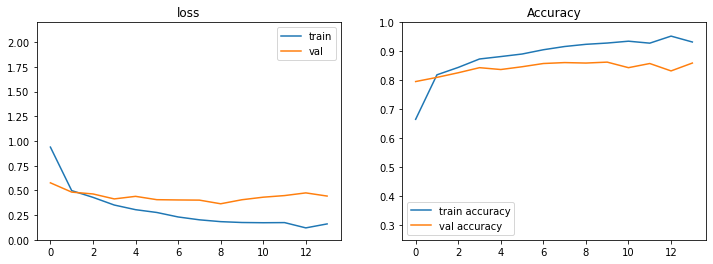

In [35]:
plot_history(history)
plt.show()

In [36]:
from tensorflow.keras import models

# Let's say that you have a `model`
# You can save it :
models.save_model(model, '/content/drive/MyDrive/models/model4')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/model4/assets


In [37]:
from tensorflow.keras import models
loaded_model = models.load_model('/content/drive/MyDrive/models/model4')

In [38]:
loaded_model

In [39]:
dataset_path_test ="/content/drive/MyDrive/testset"

In [41]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_path_test,
  seed=123,
  image_size=(256, 256),batch_size=32)

Found 1346 files belonging to 4 classes.


In [42]:
test_ds

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

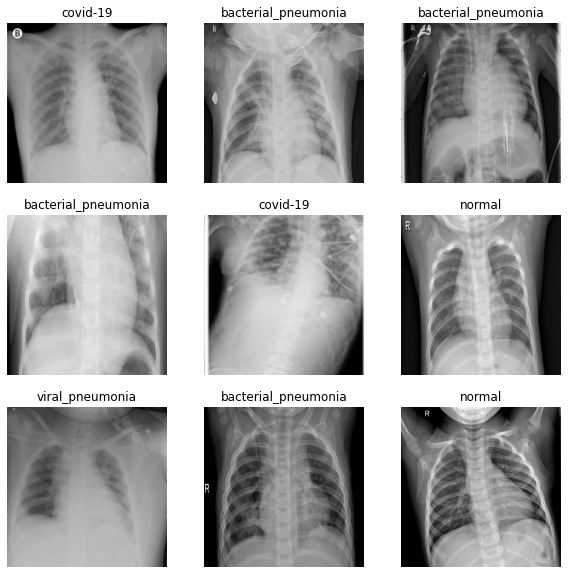

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [47]:
normalized_test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch_test, labels_batch_test = next(iter(normalized_test_ds))
first_image_test = image_batch_test[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image_test), np.max(first_image_test)) 

0.0 1.0


In [ ]:
#test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [48]:
loaded_model.evaluate(normalized_test_ds, verbose=1)



43/43 [==============================] - 12s 235ms/step - loss: 1.0322 - accuracy: 0.7169


[1.03218674659729, 0.7169390916824341]

In [44]:
labels = []
images = []
for image, label in test_ds:
  labels += list(np.array(label))
  images += list(np.array(image))

In [45]:
import numpy as np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


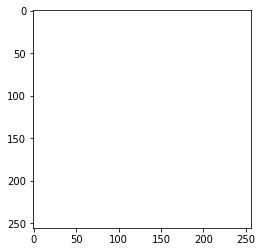

In [46]:
plt.imshow(np.array(images[100]))

In [49]:
np.array(labels).shape

(1346,)

In [50]:
y_true = np.array(labels)

In [52]:
predictions = loaded_model.predict(normalized_test_ds)

In [53]:
y_pred = np.array([np.argmax(x) for x in predictions])

In [54]:
y_true

array([1, 0, 3, ..., 2, 1, 2], dtype=int32)

In [55]:
import numpy as np

In [56]:
number_list = y_pred

(unique, counts) = np.unique(number_list, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)

[[  0 436]
 [  1 218]
 [  2 350]
 [  3 342]]


In [57]:
number_list = y_true

(unique, counts) = np.unique(number_list, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)

[[  0 560]
 [  1 196]
 [  2 288]
 [  3 302]]


In [58]:
class_names # 0, 1, 2, 3

['bacterial_pneumonia', 'covid-19', 'normal', 'viral_pneumonia']

(-0.5, 255.5, 255.5, -0.5)

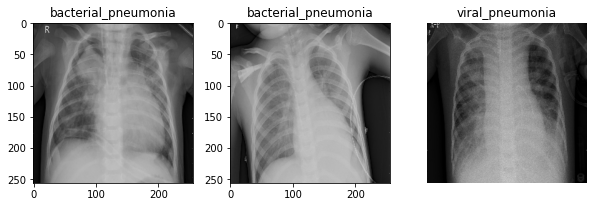

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(3):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
plt.axis("off")

In [ ]:
# Y true 1                       #3                       #0
# y pred 1                       #0                       #0
#  'covid-19'.             'bacterial_pneumonia'.     'bacterial_pneumonia'

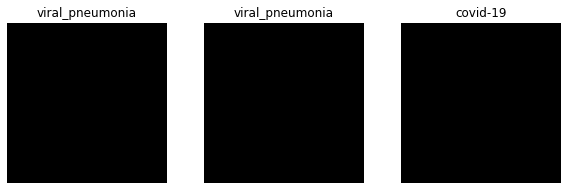

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in normalized_test_ds.take(1):
  for i in range(3):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [66]:
from sklearn.metrics import confusion_matrix
import pandas as pd

In [63]:
cm = confusion_matrix(y_true,y_pred)

In [64]:
labels = ['bacterial_pneumonia', 'covid-19', 'normal', 'viral_pneumonia']

In [67]:
df_cm = pd.DataFrame(cm, index = [i for i in labels],
                  columns = [i for i in labels])

In [68]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

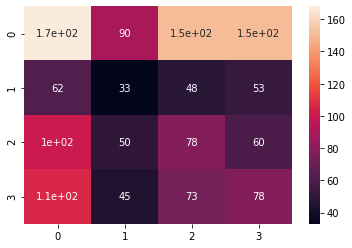

In [69]:
sns.heatmap(cm, annot=True)

In [70]:
np.array_equal(y_true,y_pred)

False

In [71]:
np.not_equal(y_true,y_pred)

array([ True,  True,  True, ...,  True,  True,  True])

In [72]:
y_pred[1]

3

In [73]:
y_true[1]

0

In [74]:
 from sklearn.metrics import classification_report

In [75]:
target_names =['bacterial_pneumonia', 'covid-19', 'normal', 'viral_pneumonia']
print(classification_report(y_true, y_pred, target_names=target_names))

                     precision    recall  f1-score   support

bacterial_pneumonia       0.39      0.30      0.34       560
           covid-19       0.15      0.17      0.16       196
             normal       0.22      0.27      0.24       288
    viral_pneumonia       0.23      0.26      0.24       302

           accuracy                           0.27      1346
          macro avg       0.25      0.25      0.25      1346
       weighted avg       0.28      0.27      0.27      1346

